# Angular integration over "quad" grid

We have the following type of grid which we will integrate over

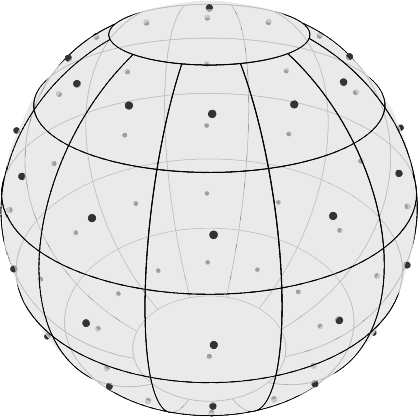

In [2]:
using Images
using FileIO
load("/home/oliver/academic/research/thesis/figures/png/angulargrid.png")

In [3]:
using SymPy
using Cubature
using Plots; pyplot()

Plots.PyPlotBackend()

In [4]:
function gengrid(nθ, nϕ)
    """generate grid. nϕ includes poles."""
    dθ = 2π/(nθ)
    dϕ = π/(nϕ-1)

    l = 1:nθ
    m = 1:nϕ
    θ = collect((l-1)*dθ)
    ϕ = collect((m-1)*dϕ)

    # edges between cells
    θe = θ+dθ/2
    ϕe = ϕ[1:nϕ-1]+dϕ/2
    #ϕe[1] = dϕ/2
    #ϕe[nϕ-1] = π - dϕ/2
    
    return dθ, θ, θe, dϕ, ϕ, ϕe
end

function plotgrid(θ, θe, ϕ, ϕe)
    l = @layout [a b]
    θs = linspace(0,2π,101)
    ϕs = linspace(0,π,101)
    # azimuthal grid
    p = plot(cos.(θs), sin.(θs), label="", layout=l)
    plot!(p[1], cos.(θ), sin.(θ), marker=:circle, lw=0, label="cells")
    plot!(p[1], cos.(θe), sin.(θe), marker=:cross, lw=0, label="edges")
    plot!(p[1], aspectratio=1)
    title!(p[1], "azimuthal grid (\$\\theta\$)")
    # polar grid
    plot!(p[2], sin.(ϕs), cos.(ϕs), label="")
    plot!(p[2], sin.(ϕ), cos.(ϕ), marker=:circle, lw=0, label="cells")
    plot!(p[2], sin.(ϕe), cos.(ϕe), marker=:cross, lw=0, label="edges")
    plot!(p[2], aspectratio=1)
    title!(p[2], "polar grid (\$\\phi\$)")
end

function angularquad(f, nθ, nϕ)
    dθ, θ, θe, dϕ, ϕ, ϕe = gengrid(nθ, nϕ)
    display(plotgrid(θ, θe, ϕ, ϕe))
    
    # initialize with value only considering poles
    integ = 2π*(1-cos(dϕ/2))*(f[1,1]+f[1,nϕ])
    println("np = $(f[1,1])")
    println("sp = $(f[1,nϕ])")
    println("poles = $integ")
    # exclude poles
    for l=1:nθ
        for m=2:nϕ-1
            #println("l=$l, m=$m")
            integ += f[l,m] * dθ * (cos(ϕe[m-1])-cos(ϕe[m]))
        end
    end
    
    return integ
end

angularquad (generic function with 1 method)

In [5]:
function test_angularquad(f, nθ, nϕ)
    dθ, θ, θe, dϕ, ϕ, ϕe = gengrid(nθ, nϕ)
    println("dθ = $dθ")
    println("dϕ = $dϕ")
    println("cos_phi_edge = $(cos.(ϕe))")
    f_arr = [f(θ1, ϕ1) for θ1=θ, ϕ1=ϕ]
    grid_integ = angularquad(f_arr, nθ, nϕ)
    println("grid_integ = $grid_integ")
    cubature, cube_err = hcubature(ω -> begin (θ, ϕ) = ω; sin(ϕ)*f(θ, ϕ) end, (0.,0.), (2π,π), reltol=1e-4, abstol=1e-4)
    println("cubature = $cubature")
    @syms x y
    sym_integ = N(integrate(sin(y)*f(x,y), (x,0,2π), (y,0,π)))
    println("sym_integ = $sym_integ")
end

test_angularquad (generic function with 1 method)

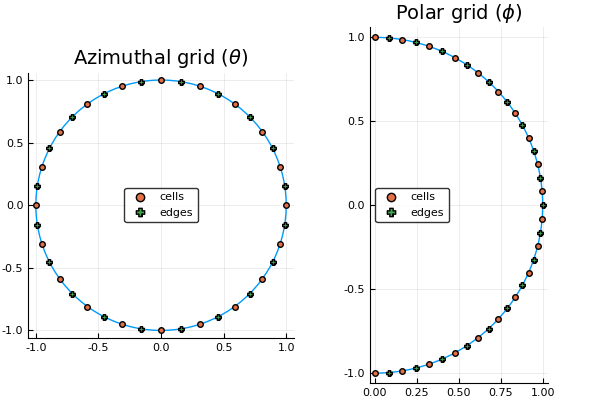

dθ = 0.3141592653589793
dϕ = 0.16534698176788384
cos_phi_edge = [0.996584, 0.9694, 0.915773, 0.837166, 0.735724, 0.614213, 0.475947, 0.324699, 0.164595, 6.12323e-17, -0.164595, -0.324699, -0.475947, -0.614213, -0.735724, -0.837166, -0.915773, -0.9694, -0.996584]
np = 1.1
sp = 1.0999999999999999
poles = 0.04721257938553451
grid_integ = 12.57066266703058
cubature = 12.564665896772182
sym_integ = 12.566370614359172


In [9]:
nθ = 20
nϕ = 20
f(θ, ϕ) = 1+.1*(sin(10*ϕ)+cos(10*θ))
test_angularquad(f, nθ, nϕ)
#savefig("angular_grid_plots.pdf")